In [1]:
%load_ext autoreload
%autoreload 2


# Identify transects

## Overview
This notebook contains two ways transects (i.e., boundaries of a chosen region) can be identified. 
<ol>
    <li> Given desired locations of points through which we want a transect to cross through, identify the consecutive edges and vertices between them. Then create a mask (i.e., find all the points that are enclosed by the transect). </li>
    <li> Given a mask, identify consecutive edges and vertices that are on the border of this mask.</li>
</ol>

In [2]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools
from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps

### Set up datasets
**To create a base mask (a global "mask" filled with 1s):**
```ruby
# create a global base mask of ones everywhere. 
# We will then apply the mask where we specifically choose nCells, nVertices, and nEdges that are contained in the original mask to this basemask 
# This creates a new mask with all parts of the cell included. 


# create a base mask
mask['regionCellMasks'] = mask.regionCellMasks * 0 + 1
mask['regionVertexMasks'] = mask.regionVertexMasks * 0 + 1
mask['regionEdgeMasks'] = mask.regionEdgeMasks * 0 + 1
mask['regionNames'] = 'whole cell LS'
mask.attrs['How to use'] = 'open separate dataset with nCell, nVertices, nEdges xr index arrays. base_mask.regionCellMasks.where(base_mask.nCells.isin(cells_inside),other = 0)'
mask.to_netcdf('/global/homes/k/kuyeda/WMT_NBs/mpas-o_EC30to60_global_base_mask.nc',format='netCDF4',mode='w')
mask
```

**To switch between ID and indices** 

Code to convert between ID (called `n`) and index (called `xr`) is shown below. 
`__On__` will give `n` coordinates (IDs).

`nCells/Edges/Vertices` will give `xr` coordinates (indices).

Also, just subtracting one feels easier and there is a straightforward conversion from ID (n) to index (xr) values. But the equivalent functions are below
```ruby
def xr_to_n_idx(xr):
    return xr+1
```

The equivalent conversion from  the index (xr) to ID (n) is
```ruby
cell_part = 'Cell' # 'Edge', 'Vertex'
ds = mesh
def idx_to_id(idx,cell_part,ds):
    id = ds[f'indexTo{cell_part}ID'].isel(nCells=idx).values
    return id
```

### Open necessary datasets
```mesh``` $\rightarrow$ contains information about the mesh and cells \
```dso``` $\rightarrow$ diagnostics from the simulations (datavariables we actually want to plot) \
```mask``` $\rightarrow$ a mask of 0s and 1s created from a geojson file (created using geojson.io) that was then converted into a netcdf file using ```compute_mpas_region_masks``` \
```base_mask``` $\rightarrow$ a mask of 1s for the entire globe.


In [3]:
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')


/tmp/ipykernel_737257/638316685.py:10: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')


In [4]:
# set up descriptor for plotting 
# # set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

## Part 1: Algorithm to create transects
### Identify transect based on desired transect location

In [23]:
LS_lats= np.array([54, 60, 66, 64, 58])   
LS_lons= np.array([302, 315, 310, 295, 296])

LS_lats = np.append(LS_lats, LS_lats[0])
LS_lons = np.append(LS_lons, LS_lons[0])

# calculate transects from algorithm, sort vertices & edges to be in consecutive order
test_edges, test_verts = mps.calculate_transects_multiple_pts(LS_lons, LS_lats, mesh)

# from the transect, create a mask to capture the entire region specified by the transects
# this will also output lats and lons corresponding to test_verts
path = './'
filename = 'LS_test'
geojson_file_name = 'Labrador Sea from transect algorithm'
tags = "Labrador_Sea;Davis_Strait"
author = "Kaila Uyeda"

    
test_verts_lats, test_verts_lons, dsMasks = mps.transect_from_alg_create_nc(test_verts, 
                                                                            mesh, 
                                                                            path,
                                                                            filename, 
                                                                            geojson_file_name,
                                                                            tags, 
                                                                            author)

# use the dsMasks file to get the ACTUAL working vertices that you will need
# this eliminates duplicate vertices that would occur if the transect moves back on itself
# check that the vertices and edges from the mask are actually at the same plaaces...
# in other words, we have the correct cells for the mask but extra edges and vertices because of how the transect is created.
# we have to do this after we create a mask with the cells. Otherwise, we don't know what side of the boundary
# is considered "inside the mask"

alg_edges, alg_vertices = mps.find_and_sort_transect_edges_and_vertices(mesh,dsMasks)

LS_test_transect_from_alg.geojson exists!
Opening LS_test_transect_from_alg.nc as dsMasks


/global/homes/k/kuyeda/.conda/envs/lanl_env/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/global/homes/k/kuyeda/.conda/envs/lanl_env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


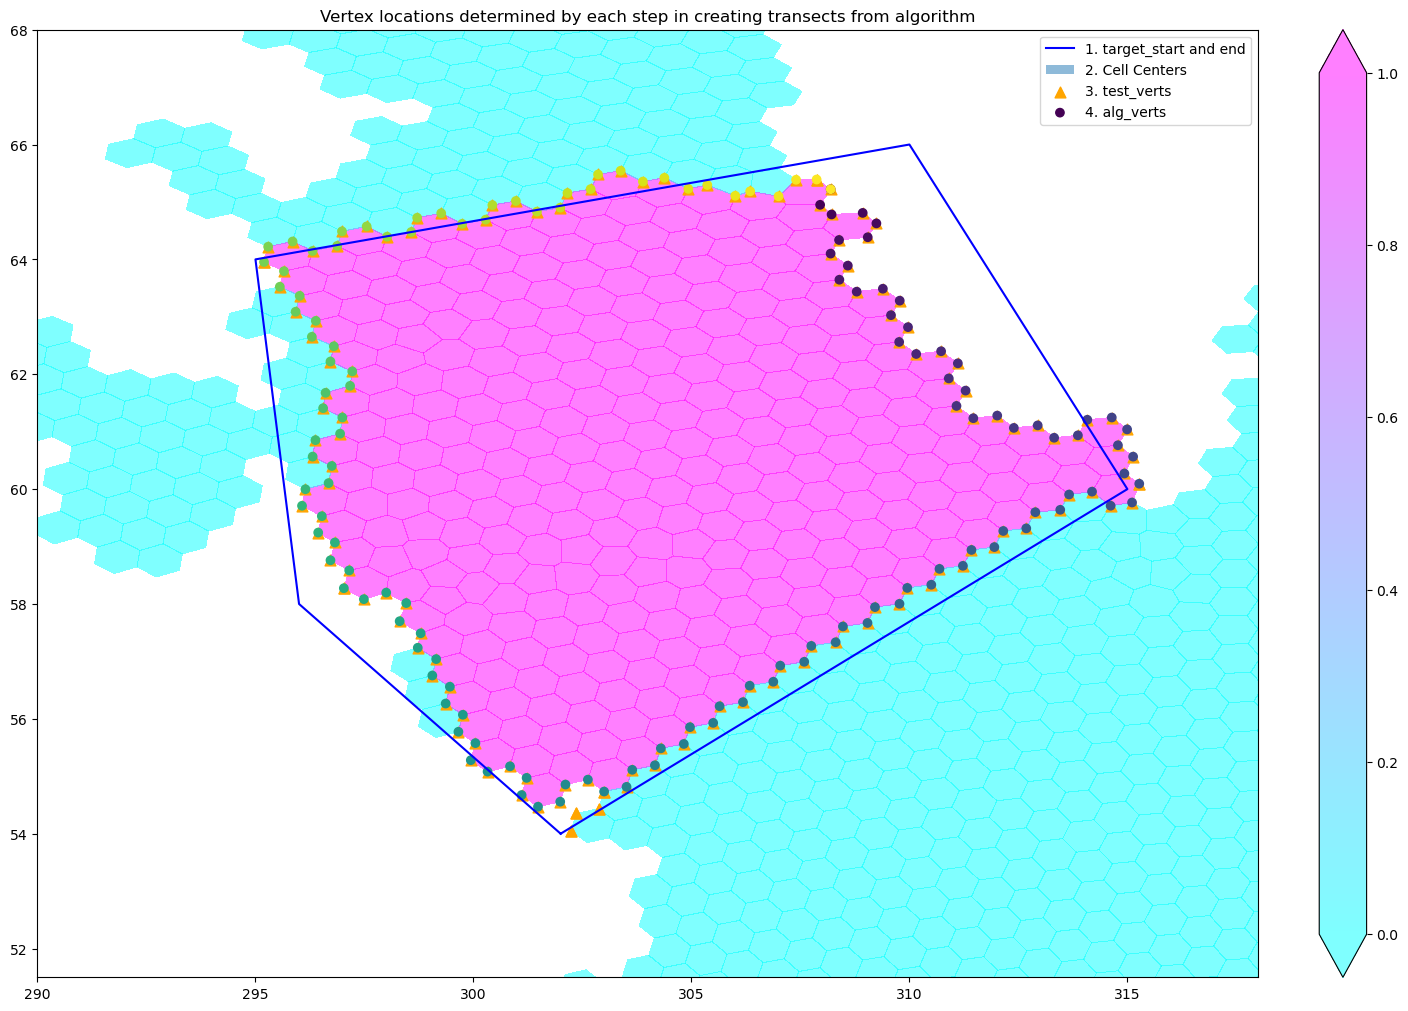

In [24]:
# plot this masked region
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

# LS the target start and end points when creating the algorithm
ax.plot(LS_lons, LS_lats, color='blue',label='1. target_start and end')

# plot the cellmask created from the cell centers in the mask (id'd with MPAS-tools)
# we don't need to worry about the mps.find_and_sort_transect_edges_and_vertices function because 
# the cell centers will always be inside the mask
# create cellmasks (which cells centers are included in the masked region)

cellmask = dsMasks.regionCellMasks.isel(nRegions=0).astype(bool)
c = mosaic.polypcolor(ax,descriptor,
                  cellmask.astype(int),cmap='cool',alpha = 0.5,
                  antialiaseds=False, label = '2. Cell Centers')

fig.colorbar(c, extend='both')

# LS (lats and lons of vertices from transect)
ax.scatter(test_verts_lons + 360,test_verts_lats, s=60,marker='^',color='orange',label='3. test_verts')


# plot using vertex lats and lons (removed vertices on cells not in the mask)
vertex_lons = mesh.lonVertex.isel(nVertices = alg_vertices) * 180 / np.pi
vertex_lats = mesh.latVertex.isel(nVertices = alg_vertices) * 180 / np.pi

# plot the vertices after removing where there are duplicates. 
# the colorbar shows the index of the lons and lats for each vertex 
# (since it is a gradient --> the vertex lats and lons are in order)
ax.scatter(vertex_lons,vertex_lats,c=np.arange(0,len(vertex_lons)),label='4. alg_verts')

ax.set_xlim(290, 318)
ax.set_ylim(51.5, 68)

ax.set_title('Vertex locations determined by each step in creating transects from algorithm')
ax.legend()

#fig.suptitle('Grid variables from mask made from transect algorithm + MPAS-Tools')

<div class="alert alert-warning" role="alert">
  <b>END OF TRANSECT CREATION FROM ALGORITHM </b> 
</div>


# Part 2: Mask to create transects

In [55]:
# open mask of desired region (this is to find transects from a pre-existing mask)

path = './'
filename = 'LS_test_transect_from_mask'

mask = mps.transect_from_mask_create_nc(path,filename)

Opening LS_test_transect_from_mask.nc file as mask


In [57]:
next_edges, next_vertices = mps.find_and_sort_transect_edges_and_vertices(mesh,mask)

Text(0.5, 0.98, 'Transect from Mask')

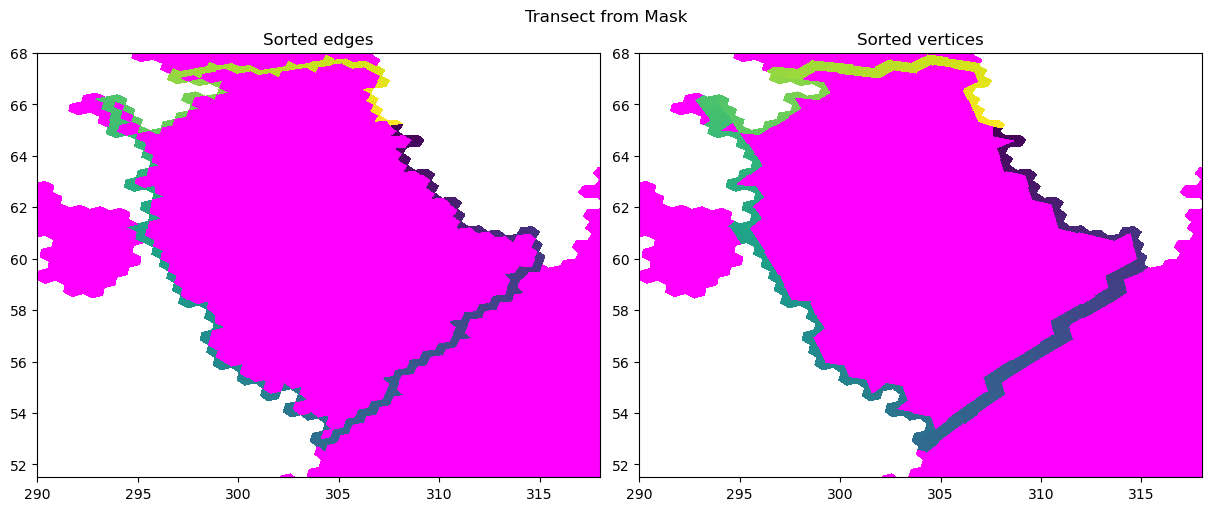

In [58]:
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')
# LS
base_mask['regionEdgeMasks'] = base_mask.regionEdgeMasks.where(base_mask.nEdges.isin(next_edges),other=0)
base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(next_vertices),other=0)

for i in range(0,len(next_edges)):
    base_mask.regionEdgeMasks.isel(nRegions=0)[np.int32(next_edges[i])]= i+1

for i in range(0,len(next_edges)):
    base_mask.regionVertexMasks.isel(nRegions=0)[np.int32(next_vertices[i])]= i+1


fig,ax = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,5))

new_cmap = plt.get_cmap('viridis')
new_cmap.set_under('magenta')

c = mosaic.polypcolor(ax[0],descriptor,
                  base_mask.regionEdgeMasks.isel(nRegions=0),cmap=new_cmap,vmin=1,
                  antialiaseds=False)

d = mosaic.polypcolor(ax[1],descriptor,
                  base_mask.regionVertexMasks.isel(nRegions=0),cmap=new_cmap,vmin=1,
                  antialiaseds=False)


# LS
for i in range(0,2):
    ax[i].set_xlim(290, 318)
    ax[i].set_ylim(51.5, 68)

ax[0].set_title('Sorted edges')
ax[1].set_title('Sorted vertices')

fig.suptitle('Transect from Mask')

Text(0.5, 0.98, 'Sorted vertex & edge locations')

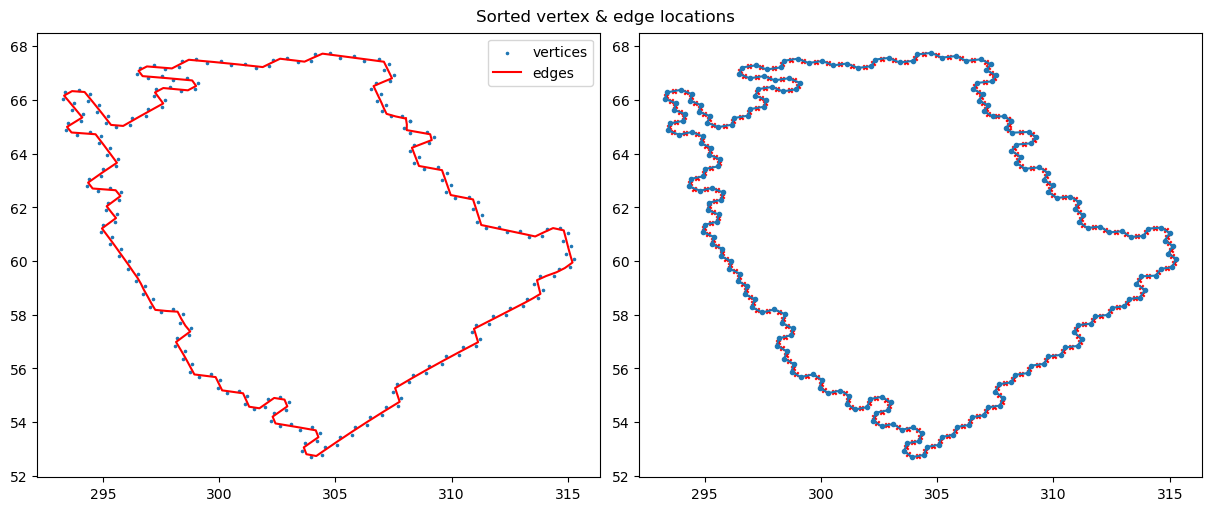

In [59]:
# plot using vertex lats and lons
vertex_lons = mesh.lonVertex.isel(nVertices = next_vertices) * 180 / np.pi
vertex_lats = mesh.latVertex.isel(nVertices = next_vertices) * 180 / np.pi

# plot using edge lats and lons
edge_lons = mesh.lonEdge.isel(nEdges = np.int32(next_edges)) * 180 / np.pi
edge_lats = mesh.latEdge.isel(nEdges = np.int32(next_edges)) * 180 / np.pi

fig,ax = plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=(12,5))
v = ax[0].scatter(vertex_lons, vertex_lats,marker='.',label='vertices')
v.set_sizes([10])
ax[0].plot(edge_lons,edge_lats,color='red',label='edges')

ax[1].plot(vertex_lons, vertex_lats, marker='.')
s = ax[1].scatter(edge_lons,edge_lats,color='red',marker='x')
s.set_sizes([10])
ax[0].legend()

fig.suptitle('Sorted vertex & edge locations')